In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import seaborn
import sys
import copy
import os
from utilities.produce_interpretable_tree import produce_interpretable_tree


In [22]:

df = pd.read_csv("outputsOfInterest300.csv", sep=",") # Read the CSV file
df = df.drop(columns=['iteration']) # Drop the iteration column
df= df.abs() # Take the absolute value of all columns

folder = "./biomass_results/"
if not os.path.exists(folder): # Create the folder if it does not exist
    os.makedirs(folder)


# Combine 'LTH', 'DH', and 'SpaceHeating' columns
df['LTH'] = df['LTH'] + df['DH'] + df['SpaceHeating']

# Drop the original 'DH' and 'SpaceHeating' columns
df = df.drop(columns=['DH', 'SpaceHeating'])

# Combine 'MTH' and 'HTH' 
df['HTH'] = df['MTH'] + df['HTH']

# Drop the original 'DH' and 'SpaceHeating' columns
df = df.drop(columns=['MTH'])


# drop columns because of too low values
df = df.drop(columns=['CHP', 'LTH', 'HTH', 'rawBiogas', 'coal'])
df = df[:100]
print(df)

# Normalize each column
for column in df.columns:
    max_value = df[column].max()
    df[column] = df[column] / max_value

# Now df contains the normalized values
print(df.head())


df.to_csv(folder+"df_input_normalized.csv",sep=";")






      crudeOil         HVC      syngas
0   339.534432  554.772833    0.381397
1   310.689575  476.935685    0.753880
2   132.519321  386.709035  150.597775
3   452.729129  496.430914    0.276884
4   316.024842  500.452044    0.307624
..         ...         ...         ...
95  335.112046  372.300904    0.307053
96  152.239739  517.902817  146.839524
97  334.812021  501.670678    0.450192
98  160.560216  470.546570  188.643078
99  358.309836  348.887111    0.527763

[100 rows x 3 columns]
   crudeOil       HVC    syngas
0  0.749973  0.893758  0.001645
1  0.686259  0.768360  0.003252
2  0.292712  0.623002  0.649722
3  1.000000  0.799767  0.001195
4  0.698044  0.806245  0.001327


	oil	HVC	syngas	
2& 	1& 	0& 	0& 	\
3& 	0& 	0& 	2& 	\
4& 	0& 	1& 	2& 	\
5& 	1& 	2& 	1& 	\
6& 	1& 	2& 	2& 	\
7& 	2& 	3& 	1& 	\
8& 	2& 	3& 	2& 	\
9& 	3& 	3& 	2& 	\
10& 	2& 	4& 	3& 	\
11& 	4& 	5& 	1& 	\
12& 	3& 	5& 	3& 	\
13& 	3& 	6& 	3& 	\
14& 	5& 	6& 	2& 	\
15& 	5& 	6& 	3& 	\
16& 	7& 	6& 	2& 	\
17& 	5& 	7& 	4& 	\
18& 	7& 	7& 	3& 	\
19& 	9& 	6& 	3& 	\
20& 	8& 	9& 	2& 	\
21& 	7& 	7& 	6& 	\
22& 	5& 	13& 	3& 	\
23& 	7& 	10& 	5& 	\
24& 	7& 	11& 	5& 	\


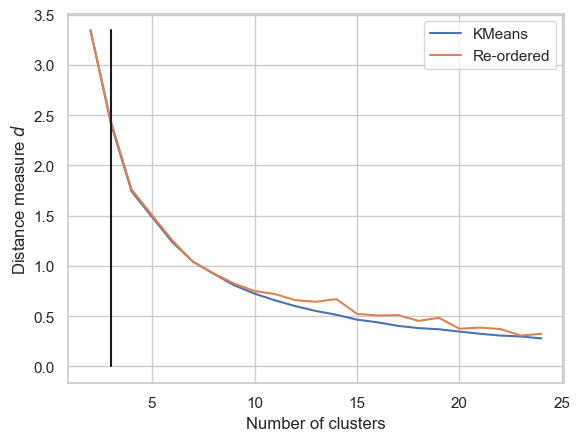

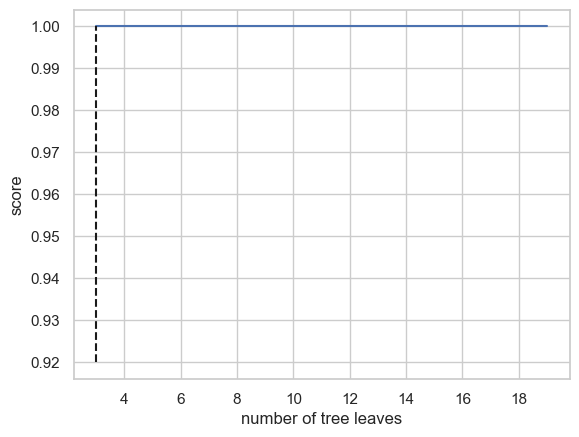

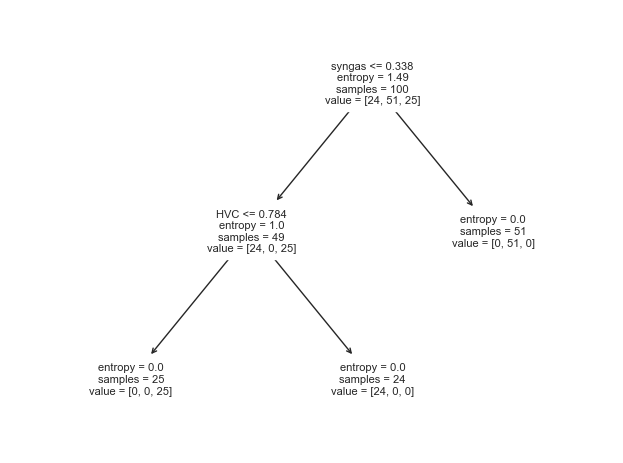

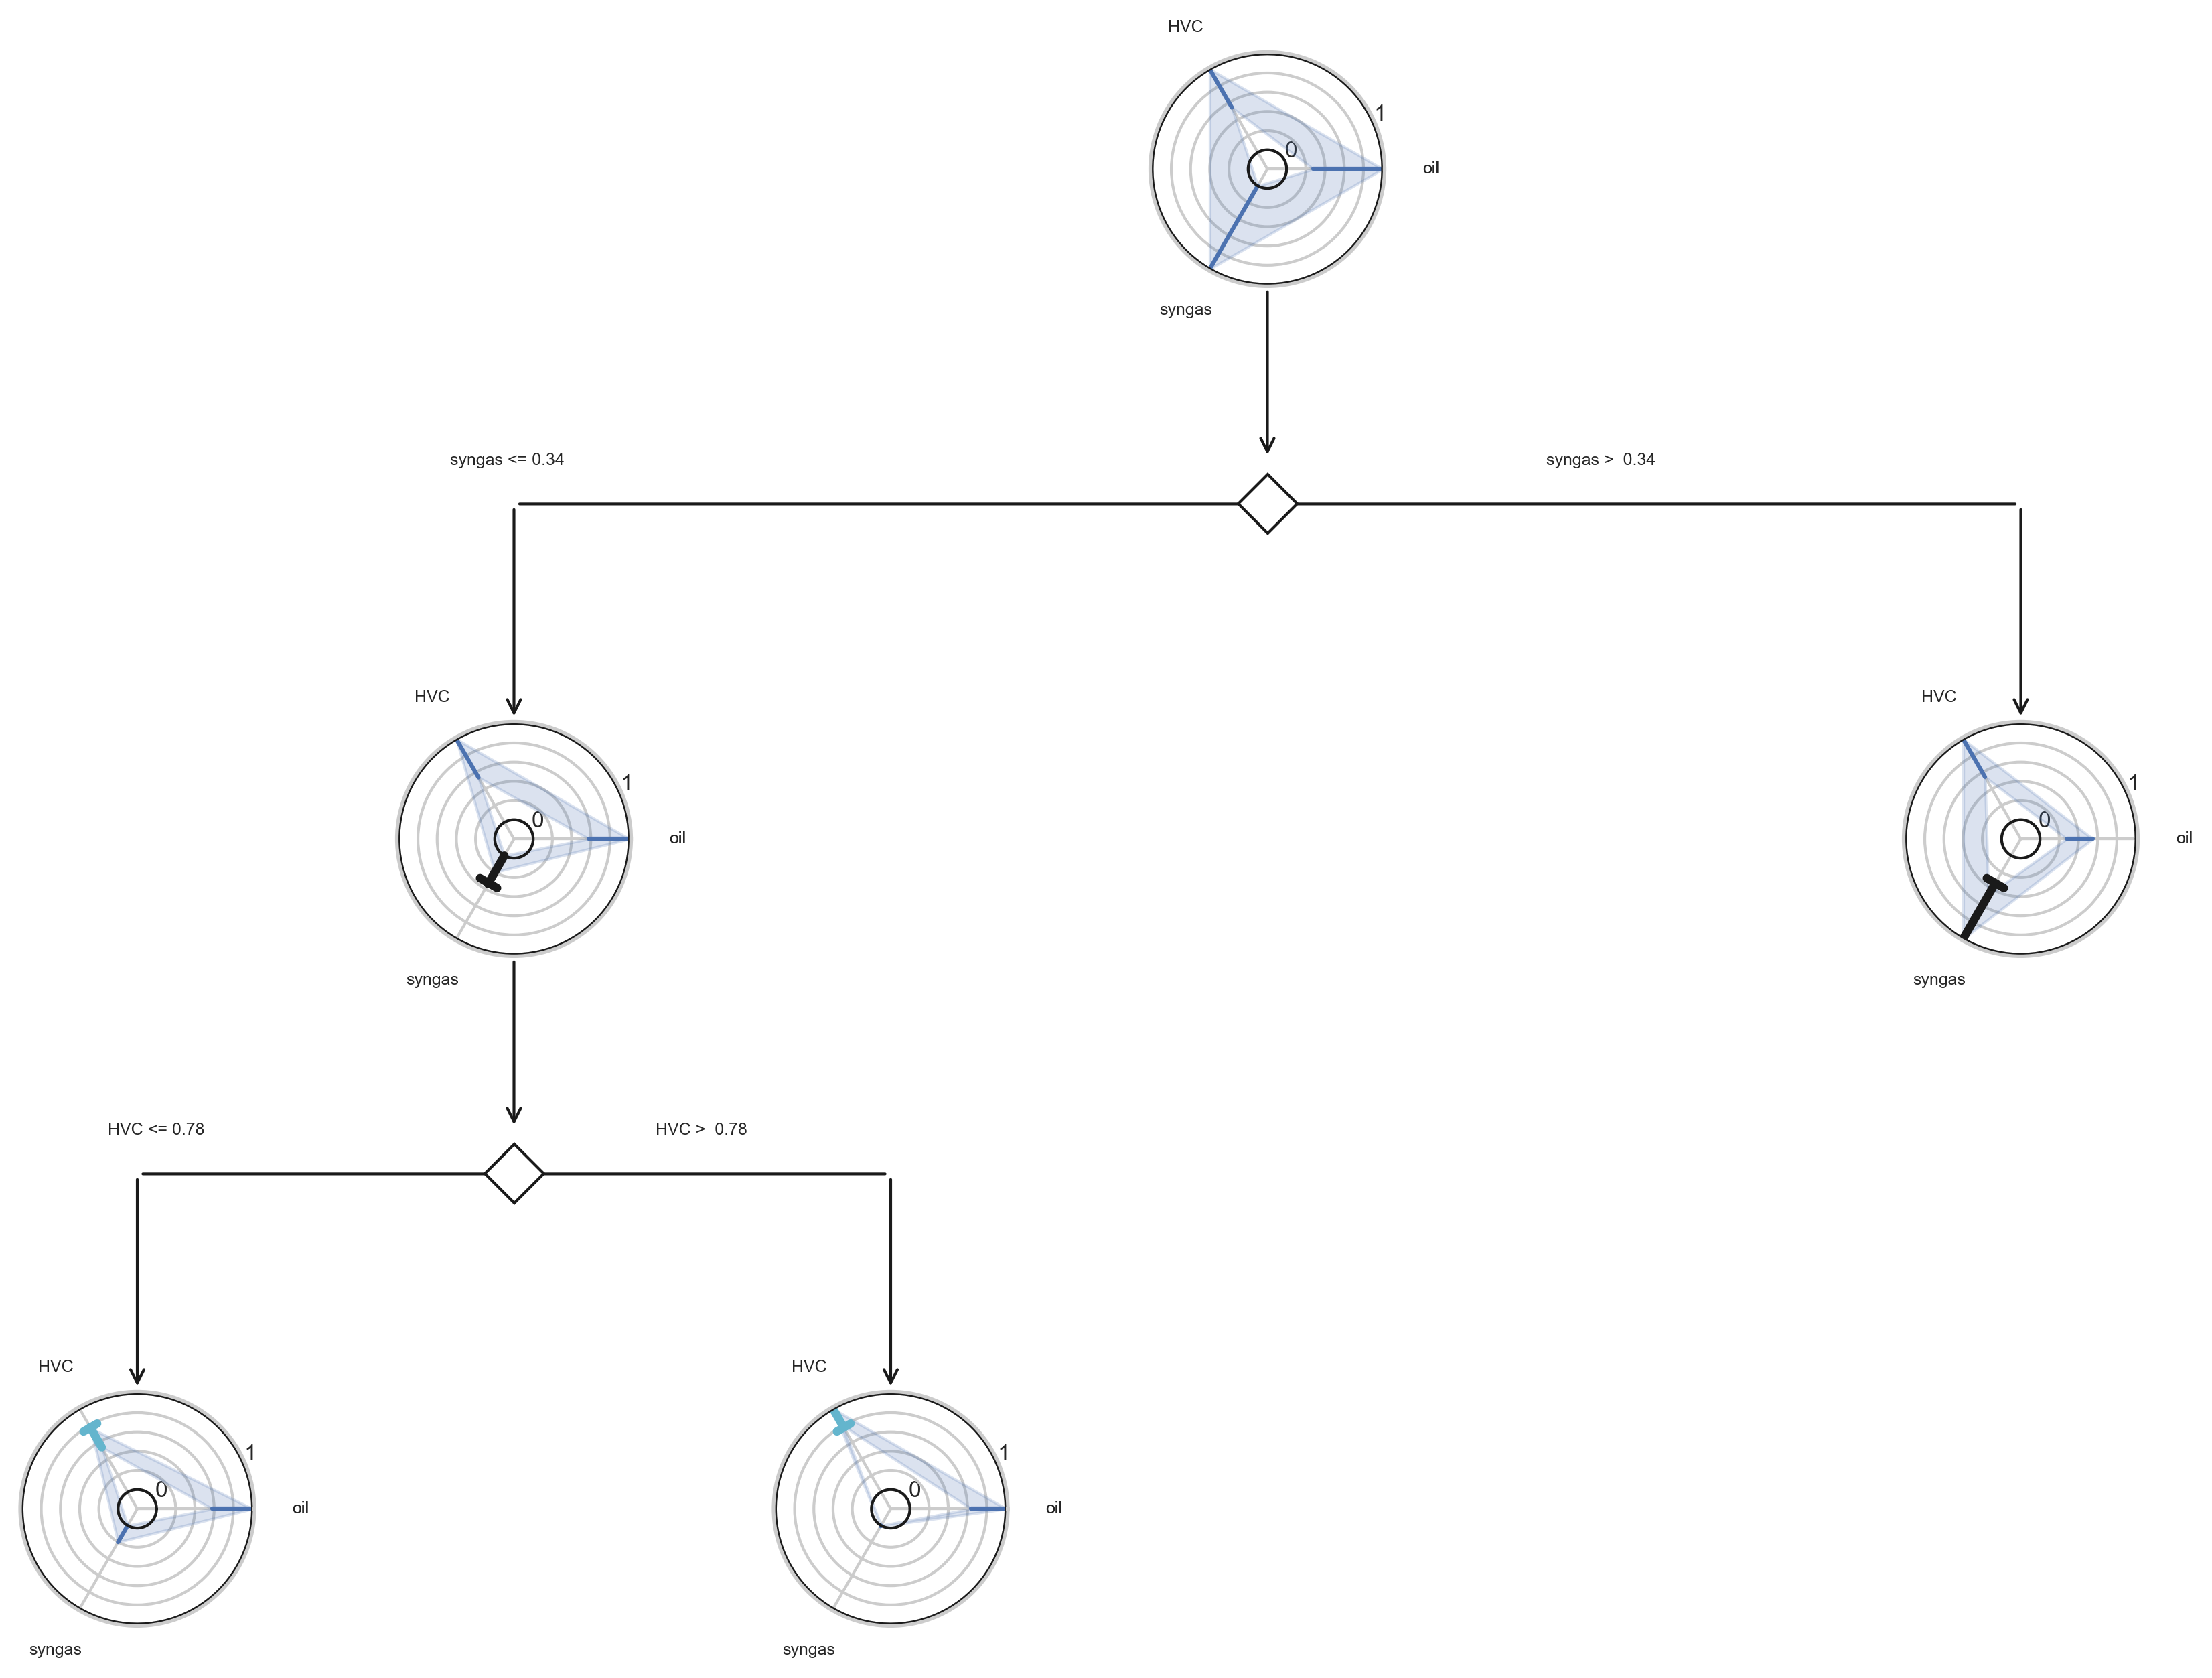

In [23]:
seaborn.set(style = 'whitegrid')  # Set the style for seaborn

n_cl = 3 # Number of clusters
# short_names = ["oil", "HVC", "CHP", "LTH", "HTH", "biogas", "syngas", "coal"]
short_names = ["oil", "HVC", "syngas"]

# Set the flag to save the results
save_results = False

# Read the CSV file
folder = "./biomass_results/"
df_input = pd.read_csv(folder+"df_input_normalized.csv",sep=";")
df_input = df_input.set_index("Unnamed: 0")

# Produce the interpretable tree
df_input_with_final_cluster, nodes, choices, decision_space = produce_interpretable_tree(df_input, short_names,n_cl, plot_all_spyders=False)

# Save the results
if save_results:
    df_input_with_final_cluster.to_csv(folder+"df_input_with_final_cluster.csv", sep = ";")
    


In [4]:
[i for i in range(3,20)]

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [7]:
list(range(3,20))

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [13]:
a = [123]
for i in range(10):
    a.append(i)
print(a)



[123, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [16]:

df = pd.read_csv("outputsOfInterest300.csv", sep=",") # Read the CSV file
df = df.drop(columns=['iteration']) # Drop the iteration column
df= df.abs() # Take the absolute value of all columns

folder = "./biomass_results/"
if not os.path.exists(folder): # Create the folder if it does not exist
    os.makedirs(folder)


# Combine 'LTH', 'DH', and 'SpaceHeating' columns
df['LTH'] = df['LTH'] + df['DH'] + df['SpaceHeating']

# Drop the original 'DH' and 'SpaceHeating' columns
df = df.drop(columns=['DH', 'SpaceHeating'])

# Combine 'MTH' and 'HTH' 
df['HTH'] = df['MTH'] + df['HTH']

# Drop the original 'DH' and 'SpaceHeating' columns
df = df.drop(columns=['MTH'])


df = df.drop(columns=['CHP', 'LTH', 'HTH', 'rawBiogas', 'coal'])
df

,crudeOil,HVC,syngas
0,339.534432,554.772833,0.381397
1,310.689575,476.935685,0.753880
2,132.519321,386.709035,150.597775
3,452.729129,496.430914,0.276884
4,316.024842,500.452044,0.307624
...,...,...,...
295,178.190941,616.269965,126.040363
296,164.458550,412.634429,167.096620
297,333.764685,591.599731,0.513381
298,277.328347,420.862093,0.572794


+---------------+-------------+-------------+
| Column Name   |   Max Value |   Min Value |
+===============+=============+=============+
| crudeOil      |     452.729 |   125.54    |
+---------------+-------------+-------------+
| HVC           |     620.719 |   334.873   |
+---------------+-------------+-------------+
| syngas        |     231.788 |     0.19115 |
+---------------+-------------+-------------+


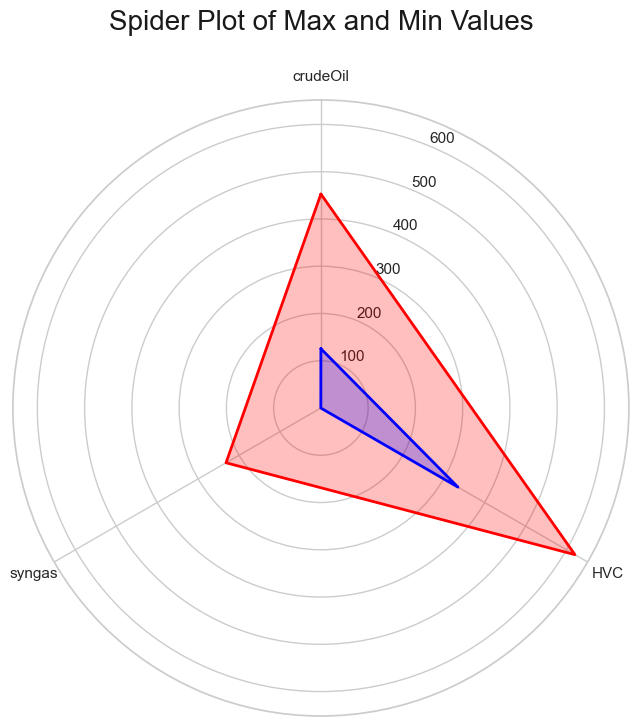

In [17]:
# Calculate the max and min values for each column
data_max = df.max().values
data_min = df.min().values

from tabulate import tabulate

# Create a list of lists with column name, max value, and min value
table_data = []
for column in df.columns:
    max_value = df[column].max()
    min_value = df[column].min()
    table_data.append([column, max_value, min_value])

# Print the table
print(tabulate(table_data, headers=["Column Name", "Max Value", "Min Value"], tablefmt="grid"))

# Number of variables
num_vars = len(df.columns)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Initialize the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Draw one axe per variable + add labels
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], df.columns)

# Draw y-labels
#ax.set_rscale('log')  # If you want log scale for better visualization
# plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=7)
# plt.ylim(0, 1)

# Plot data
values_max = data_max.tolist()
values_max += values_max[:1]
ax.plot(angles, values_max, color='red', linewidth=2, linestyle='solid', label='Max')

values_min = data_min.tolist()
values_min += values_min[:1]
ax.plot(angles, values_min, color='blue', linewidth=2, linestyle='solid', label='Min')

# Fill area
ax.fill(angles, values_max, color='red', alpha=0.25)
ax.fill(angles, values_min, color='blue', alpha=0.25)

# Add a title
plt.title('Spider Plot of Max and Min Values', size=20, color='k', y=1.1)

# Show the plot
plt.show()
